# interview assessment
By Zeid Hazboun 

The following code is my attempt to create a forecasting model to forecast three products for a 6 month period. First I will start with Data exploration and seasonal decomposition. Afterwards I will build a naive model so that we could have a baseline to compare it to. Afterwards, I will attempt to build an accurate forecast model.

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from tabulate import tabulate
import os



In [88]:
#After running for some time, I decided to remove the warning messages to make the output a bit easier to read
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

## Data Exploration
Before attempting to forecast, I first take a look at the data. I first load it in and take a visual inspection of the csv file and the features it contains

In [89]:
df = pd.read_csv("assessment_data_set.csv")
df


,Product,Month,Sales
0,ProductA,2019-03-01,608
1,ProductA,2019-04-01,6838
2,ProductA,2019-05-01,12195
3,ProductA,2019-06-01,26292
4,ProductA,2019-07-01,31547
...,...,...,...
122,ProductC,2022-09-01,7674
123,ProductC,2022-10-01,7582
124,ProductC,2022-11-01,5985
125,ProductC,2022-12-01,5489


In [90]:
#Check for missing data
df.isna().sum()

Product    0
Month      0
Sales      0
dtype: int64

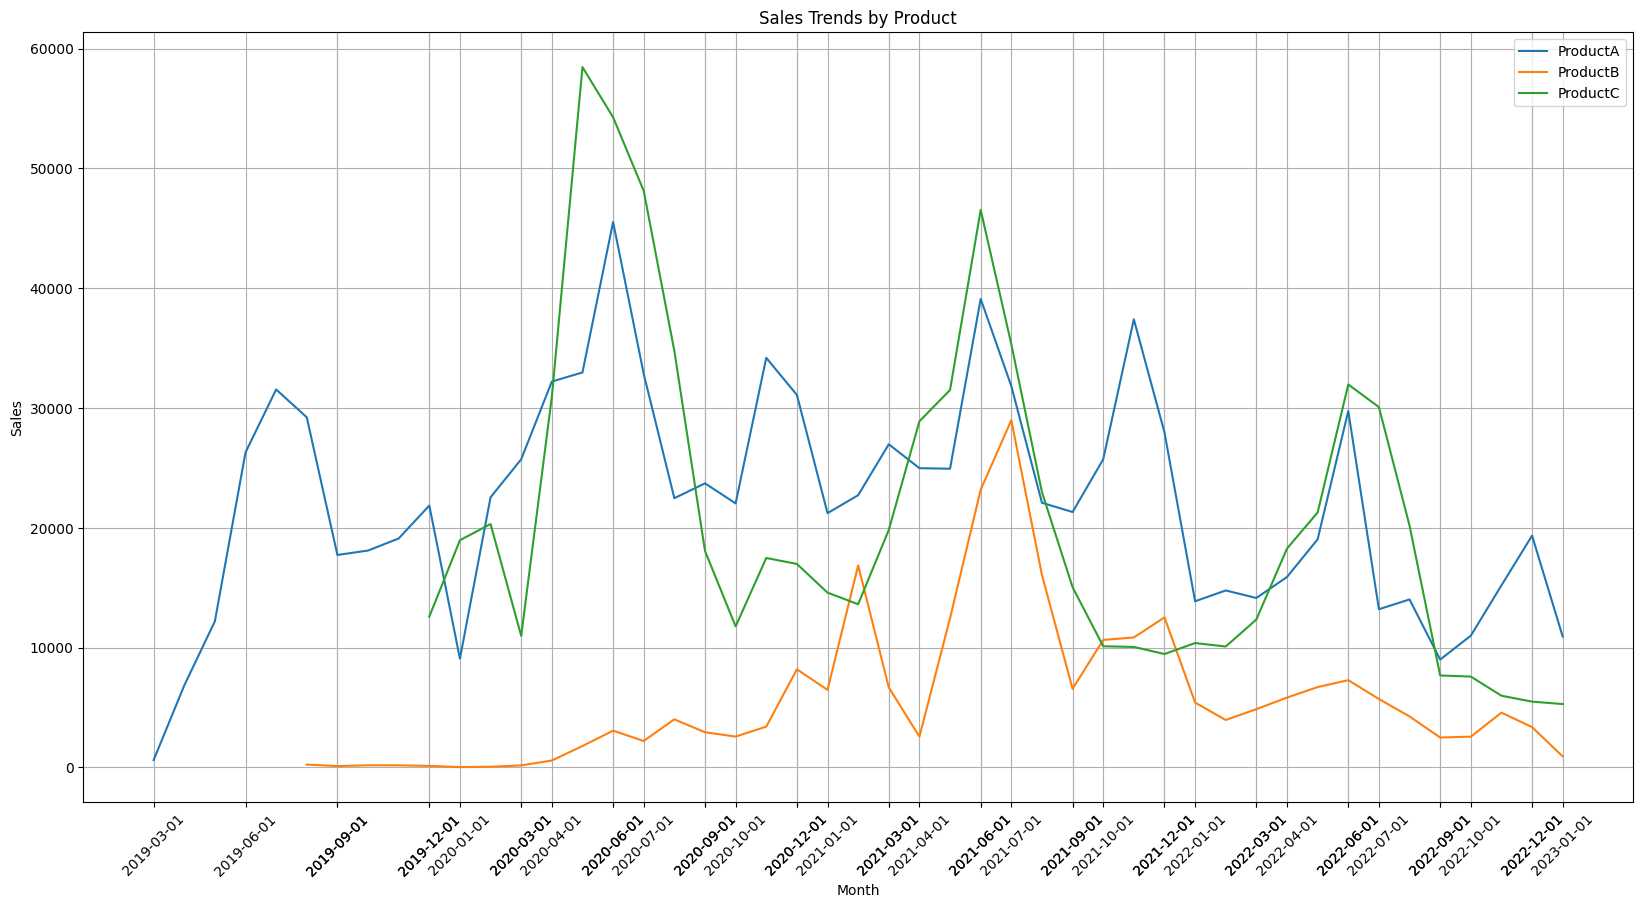

In [91]:
plt.figure(figsize=(20,10))

for product, group in df.groupby('Product'):
    plt.plot(group['Month'], group['Sales'], label=product)

# Customize plot
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales Trends by Product')
#changed the ticks so it skips a few months on the axis and rotates the labels 45 degrees. This prevents the labels from overlapping
# on the axis and keeps it readable
plt.xticks(df["Month"][::3], rotation = 45)
plt.legend()
plt.grid(True)

After plotting the trends of the products, we can see that they do indeed fluctuate based on the date, and there should be a trend that we can approximate and thus forecast the sales. 

## Data Pre-processing

After visualizing the data, we need to do a small number fo steps to get the data ready for forecasting. These are splitting the products into seperate dataframes, as well as indexing the data using the data. 

In [92]:
#For ease, the product names were changed from strings to categorical variables using the
#dictionary below.
products_dict = {"ProductA": 0, "ProductB": 1, "ProductC": 2}
df["Product"] = df.Product.replace(products_dict)
df['Month'] = pd.to_datetime(df['Month'])

# Set 'Month' column as index
df.set_index('Month', inplace=True)

/var/folders/tw/cpgzz8_54dq1wrddxy8s8dfm0000gn/T/ipykernel_93016/281104687.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Product"] = df.Product.replace(products_dict)


In [93]:
productA_data = df[df['Product'] == 0]
productB_data = df[df['Product'] == 1]
productC_data = df[df['Product'] == 2]

In [94]:
productA_data = productA_data.drop(["Product"], axis = 1)
productB_data = productB_data.drop(["Product"], axis = 1)
productC_data = productC_data.drop(["Product"], axis = 1)

In [95]:
# Split data into training and testing sets per product
trainA = productA_data[:-6]
testA = productA_data[-6:]

trainB = productB_data[:-6]
testB = productB_data[-6:]


trainC = productC_data[:-6]
testC = productC_data[-6:]

# Seasonal Decomposition

I then used seasonal decomposition to seperate the trend, seasonal, and residual patterns. This helps us understand the data itself, and decide which models would work well. 

## Product A
The seasonal decomposition shows us that there is always a spike in beer sales during the summer (peak in June4), and a drop as the weather gets colder. The trend for product A shows us that there is decline in the sales of the product. The residuals seem random, However less random than product C, and more random than product B. This explains why it is the product with the second lowest RMSE for the SARIMAX

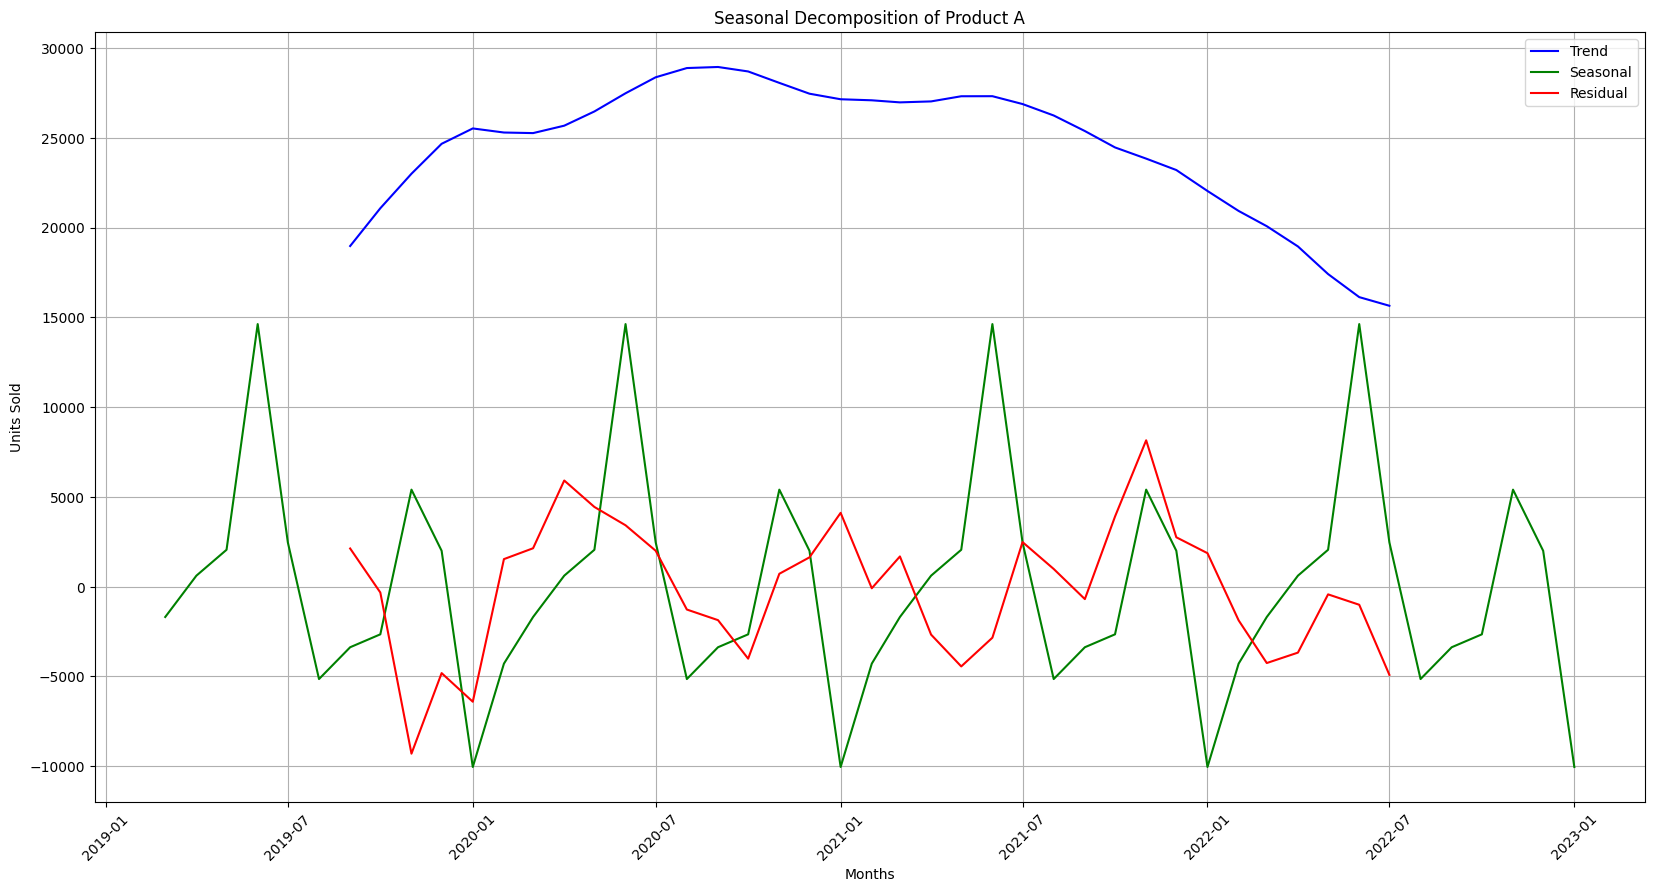

In [96]:
result = seasonal_decompose(productA_data['Sales'], model='additive')
plt.figure(figsize=(20, 10))

plt.xticks(rotation=45)
plt.xlabel("Months")
plt.ylabel("Units Sold")
plt.title("Seasonal Decomposition of Product A")
plt.plot(result.trend, label='Trend', color='blue')
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.plot(result.resid, label='Residual', color='red')
plt.grid(True)
plt.legend()
plt.show()


## Product B
The trend of product B shows a decrease in the sales of the product as well, with a similar seasonal plot. The residuals of B are the least random out of the three products, which explains why the SARIMAX model performed the worst. This means that more features are required to more accurately forecast the sales of the product.

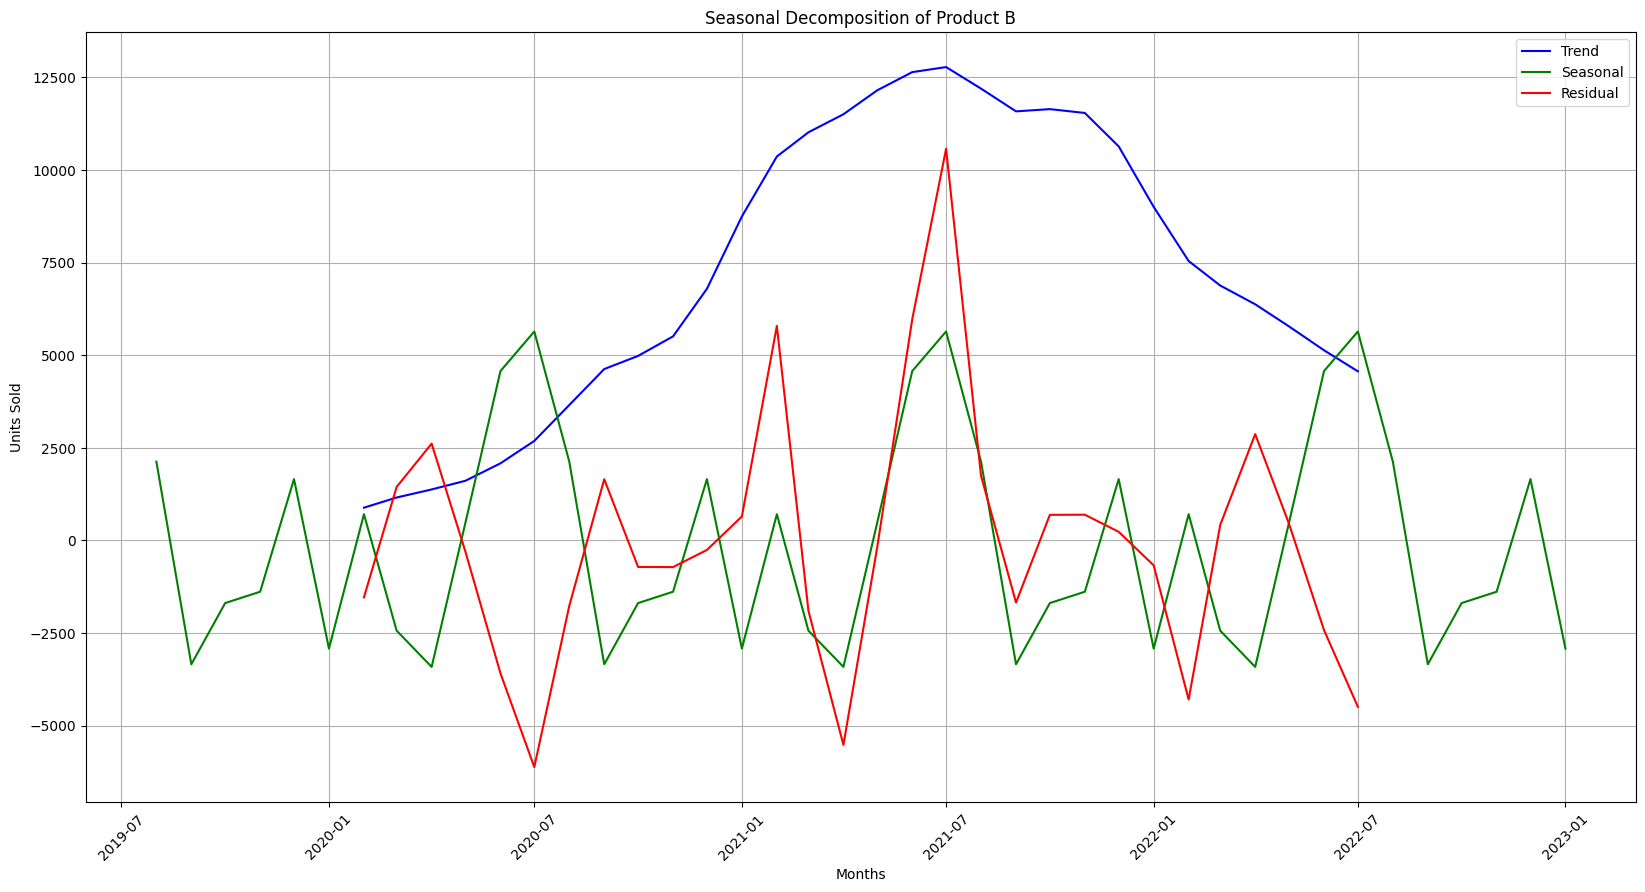

In [97]:
result = seasonal_decompose(productB_data['Sales'], model='additive')
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
plt.xlabel("Months")
plt.ylabel("Units Sold")
plt.title("Seasonal Decomposition of Product B")
plt.plot(result.trend, label='Trend', color='blue')
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.plot(result.resid, label='Residual', color='red')
plt.legend()
plt.grid(True)
plt.show()

## Product C
Product C has a trend of decreasing in sales. The seasonal plot shows a regular effect by the season, and the random residuals mean that the data would be easier to model.

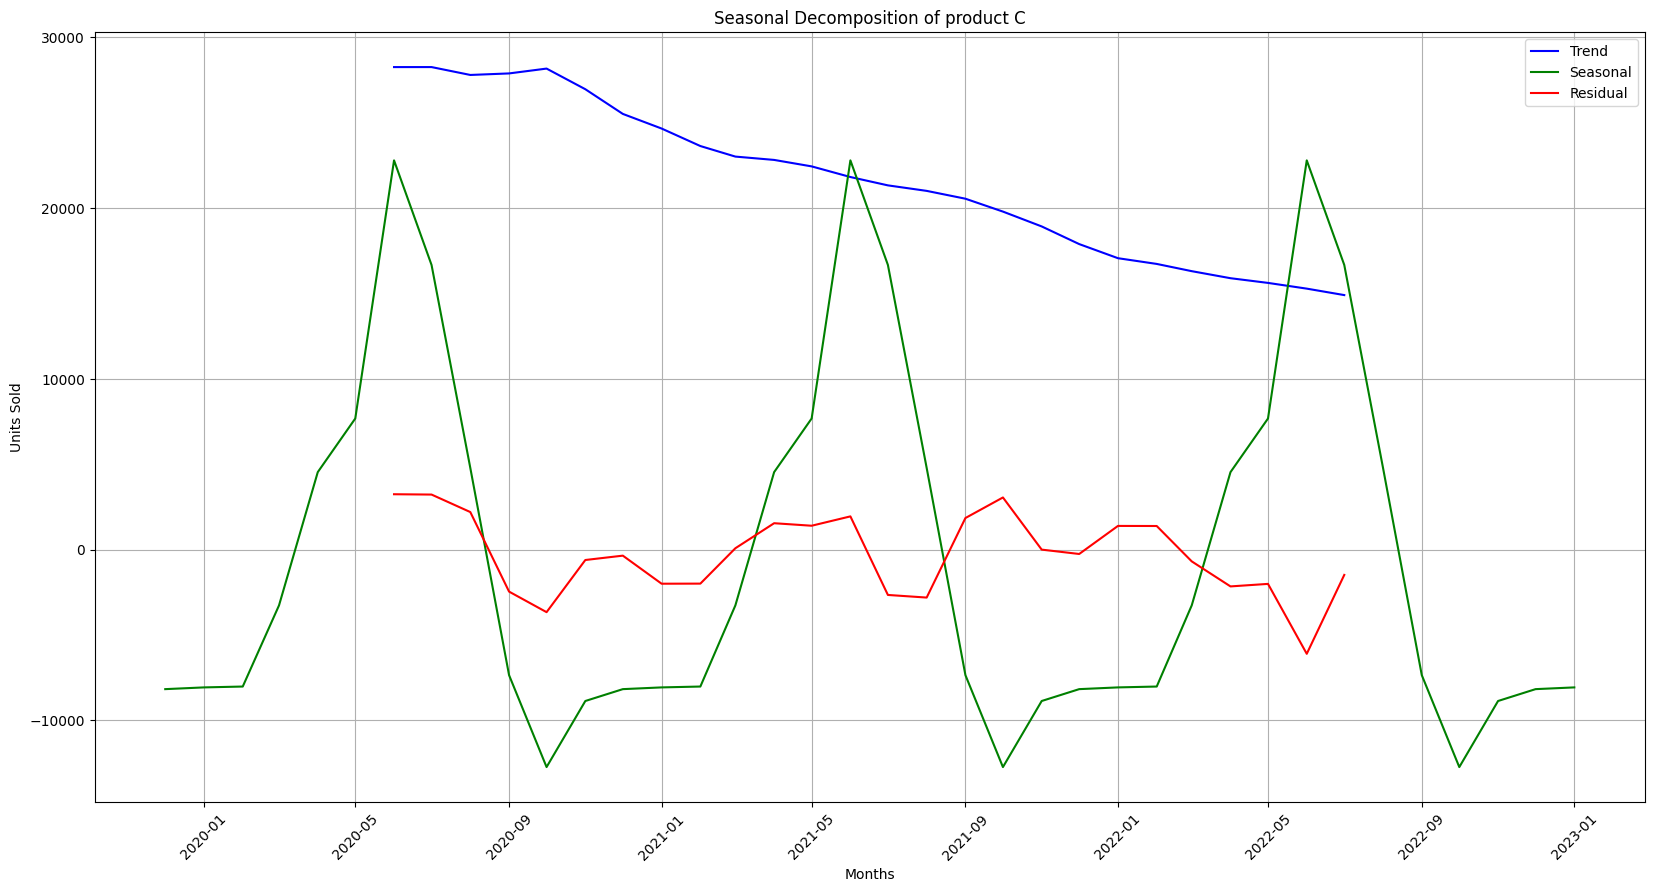

In [98]:
result = seasonal_decompose(productC_data['Sales'], model='additive')
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
plt.xlabel("Months")
plt.ylabel("Units Sold")
plt.title("Seasonal Decomposition of product C")
plt.plot(result.trend, label='Trend', color='blue')
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.plot(result.resid, label='Residual', color='red')
plt.legend()
plt.grid(True)
plt.show()

Because of the clear seasonality of the data, SARIMAX (Seasonal AutoRegressive Integrated Moving Average) would be a good model to use. 

# Forecasting
Before we attempt to build the best forecasting model, we need a baseline model to compare the RMSE to. The baseline chosen was a model that I chose was naive forecasting, that predicts future values solely based on the last observed value

In [99]:
#Making a function that calculates the rmse and plots the forececast, training, and testing data to keep the naive forecast code easier to read
def results(train, test, forecast, name, product):
    """
    Calculate the root-mean-squared error (RMSE) of a forecast and plot the results.

    Parameters:
    train (pd.DataFrame): The training data used to generate the forecast.
    test (pd.DataFrame): The test data used for evaluation.
    forecast (pd.DataFrame): The forecasted values.
    name (str): The name of the forecasting method used for plotting.
    product (str): The name or identifier of the product being forecasted.

    Returns:
    rmse (float): The root-mean-squared error (RMSE) of the forecast.
    """
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f'{name} Root Mean Squared Error: {rmse}')
    plt.figure(figsize=(20, 10))
    plt.plot(train, label='Training Data')
    plt.plot(test, label='Testing Data')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecasting for Product {product} with {name}')
    plt.legend()
    plt.grid(True)
    return rmse


In [100]:
def naive_forecast(steps, train, test, name, product):
    """
    Generate a naive forecast by repeating the last observation.

    Parameters:
    steps (int) : The number of steps (Months) to forecast.
    train (pd.DataFrame): The training data used to generate the forecast.
    test (pd.DataFrame): The test data used for evaluation.
    name (str): The name of the forecasting method for the plotting.
    product (str): The name or identifier of the product being forecasted.

    Returns:
    forecast (pd.DataFrame): A DataFrame containing the forecasted values.
    rmse (float): The root mean squared error (RMSE) of the forecast.
    """

    last_observation = train.iloc[-1]
    forecast_index = pd.date_range(start=train.index[-1], periods=steps+1, freq='MS')[1:]
    forecast_values = [last_observation] * steps
    forecast = pd.DataFrame(forecast_values, index=forecast_index)
    #I decided to round up the forecast, since it would not make sense for a prediction on the units sold to have a decimal point
    forecast = np.ceil(forecast)
    rmse = results(train, test, forecast, name, product)
    return forecast, rmse

Naive Forecasting Root Mean Squared Error: 3418.1278257744157
Naive Forecasting Root Mean Squared Error: 2948.9073682750136
Naive Forecasting Root Mean Squared Error: 22006.63875212811


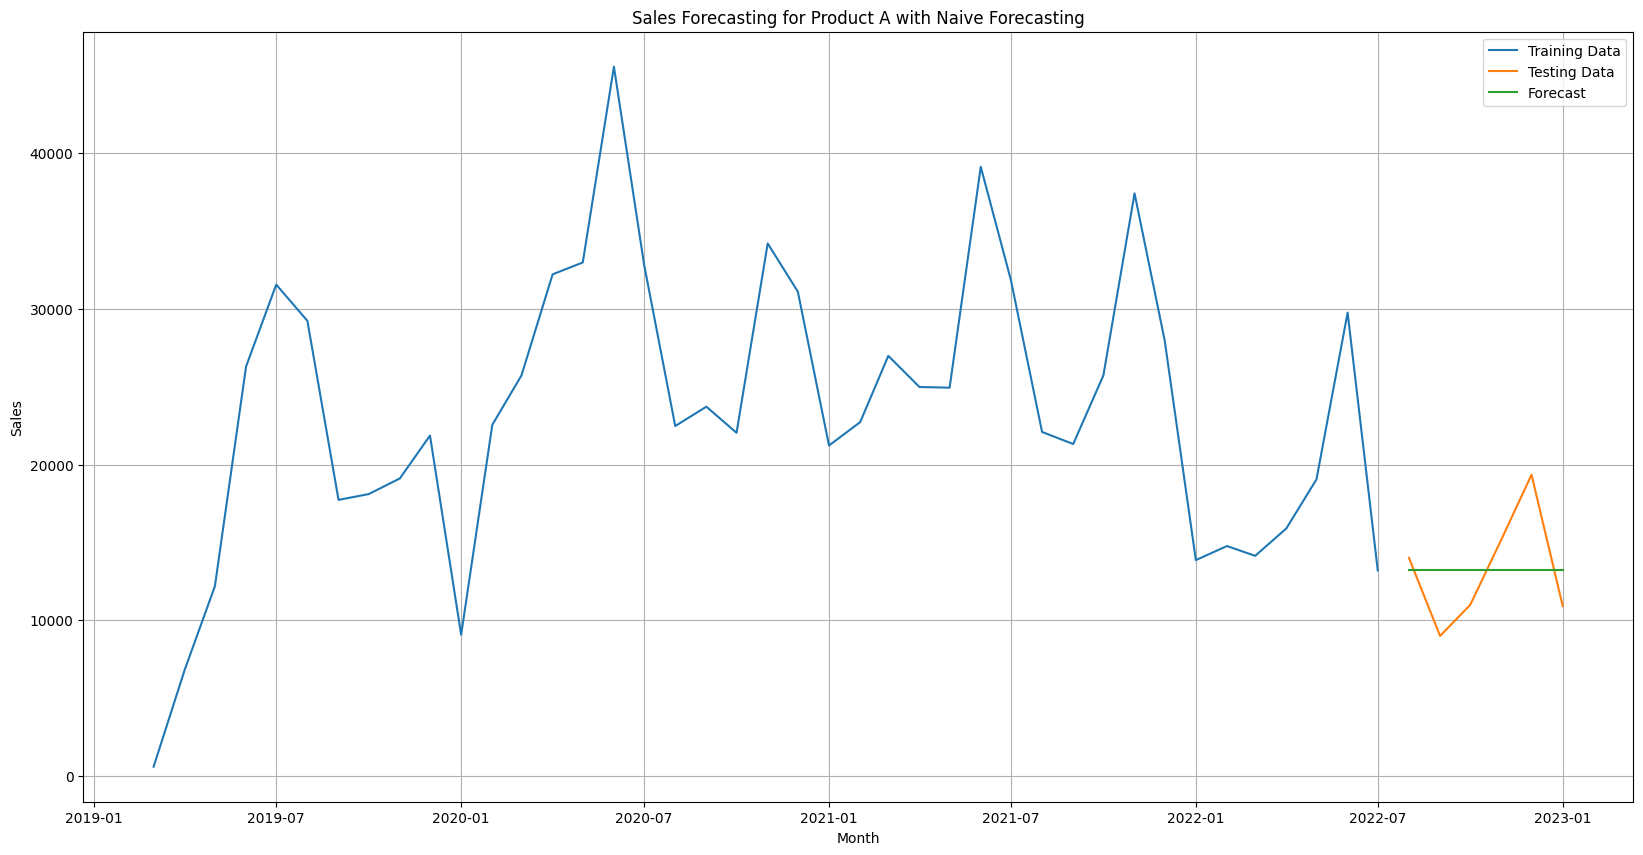

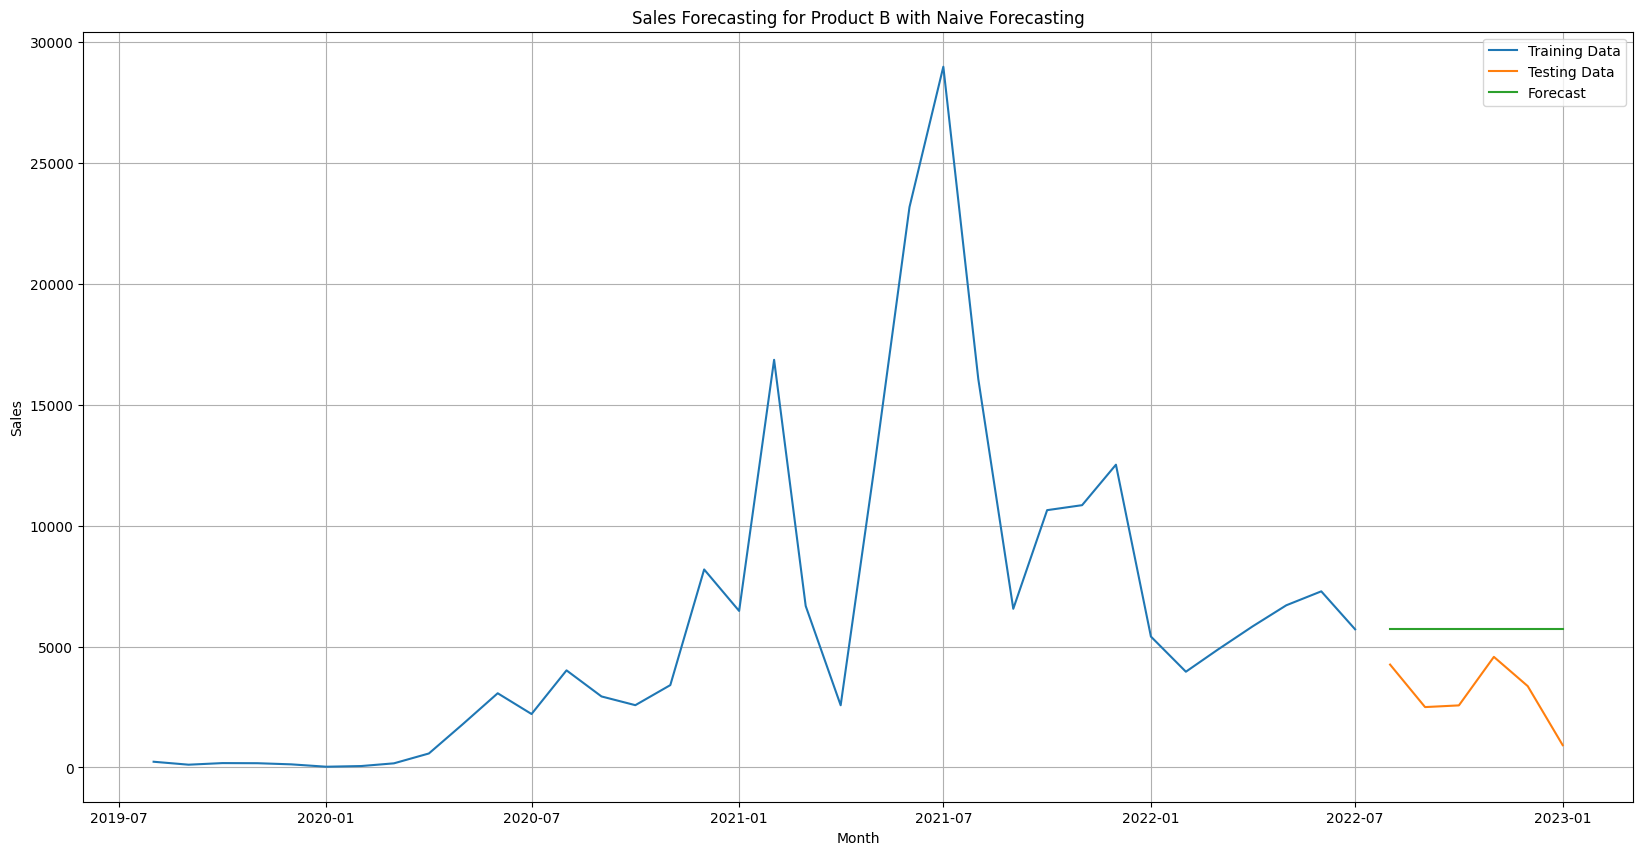

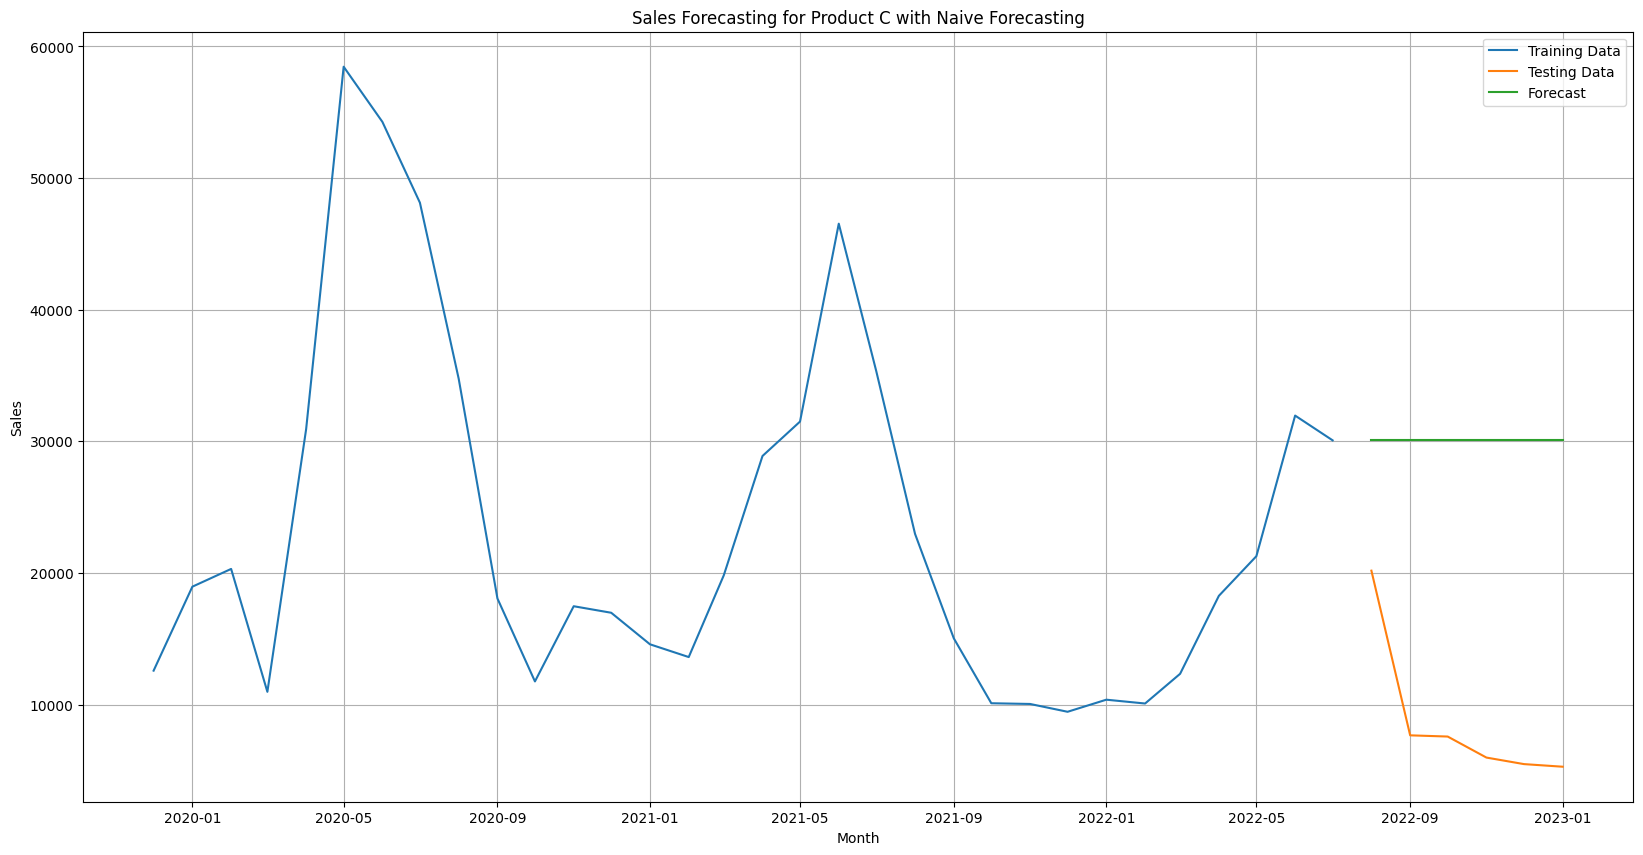

In [101]:
#Calculating the forecast for each of the products using the naive forecast
naiveA, rmseA_naive = naive_forecast(steps=6, train=trainA, test=testA, name="Naive Forecasting", product="A")
naiveB, rmseB_naive = naive_forecast(steps=6, train=trainB, test=testB, name="Naive Forecasting", product="B")
naiveC, rmseC_naive = naive_forecast(steps=6, train=trainC, test=testC, name="Naive Forecasting", product="C")


# Forecasting attempt
Now that we have established a baseline rmse for each ofhte products, we can start building a more sophisticated forecasting model. Multiple different methods can be chosen and tested, such as different types of moving average. As well as machine learning models such as random forests.

In [102]:
def SARIMAX_model(train, test, name, product):
    """
    Fit a SARIMAX model to the training data, generate forecasts, and plot the results.

    Parameters:
    train (pd.DataFrame): The training data containing historical sales.
    test (pd.DataFrame): The test data containing actual sales for evaluation.
    name (str): The name of the forecasting method for plotting.
    product (str): The name or identifier of the product being forecasted.

    Returns:
    forecast (pd.Series): A series containing the forecasted sales for the next 6 months.
    rmse (float): The root mean squared error (RMSE) of the forecast.
    """
    # Initialize SARIMAX model with default parameters
    model = SARIMAX(train['Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    
    # Fit the model to the training data
    result = model.fit()
    
    # Generate forecasts for the next 6 months
    forecast = result.forecast(steps=6)
    forecast = np.ceil(forecast)
    
    # Plot training, testing, and forecasted data
    plt.figure(figsize=(20, 10))
    plt.plot(train, label='Training Data')
    plt.plot(test, label='Testing Data')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecasting for Product {product} with {name}')
    plt.legend()
    plt.grid(True)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f'Root Mean Squared Error: {rmse}')

    # Show the plot
    plt.show()

    return forecast, rmse


/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

Root Mean Squared Error: 8104.953855513306


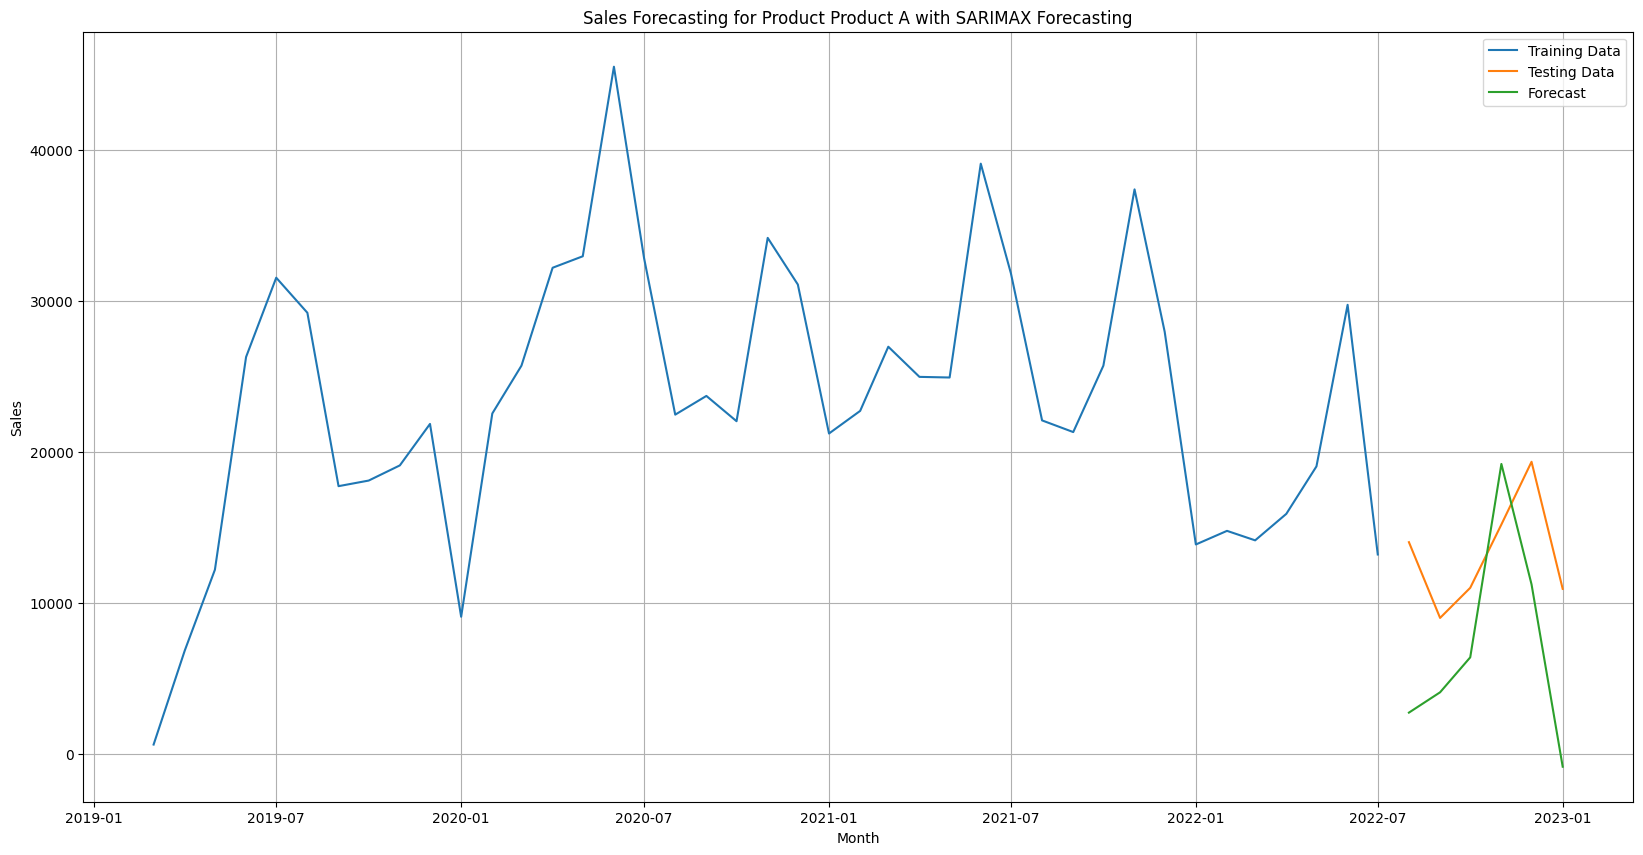

/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Root Mean Squared Error: 9061.345209183899


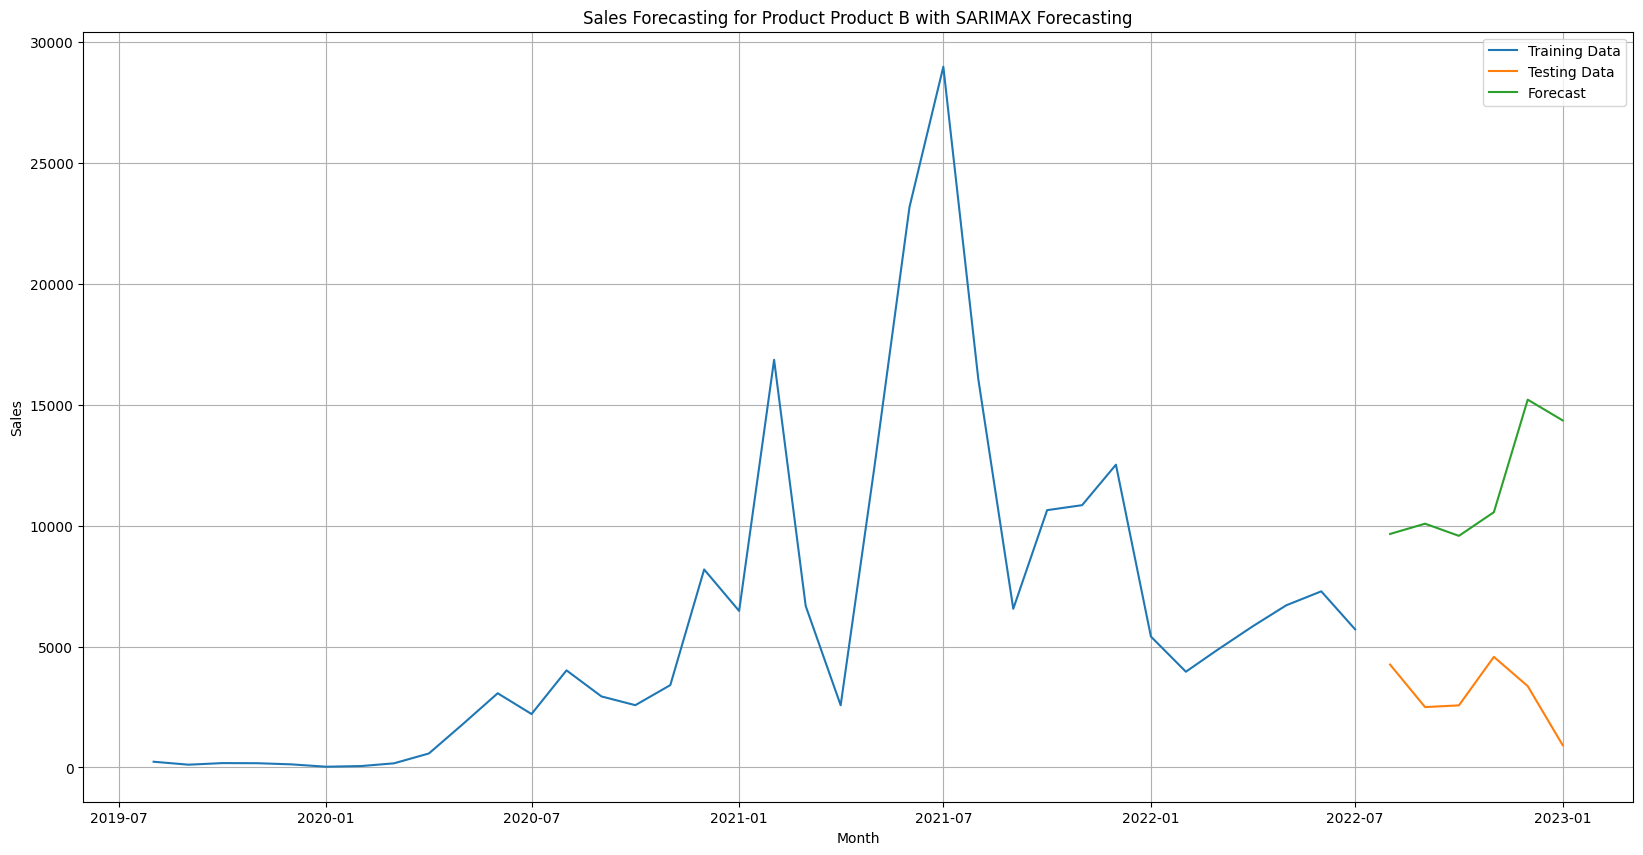

/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


Root Mean Squared Error: 2497.283424043014


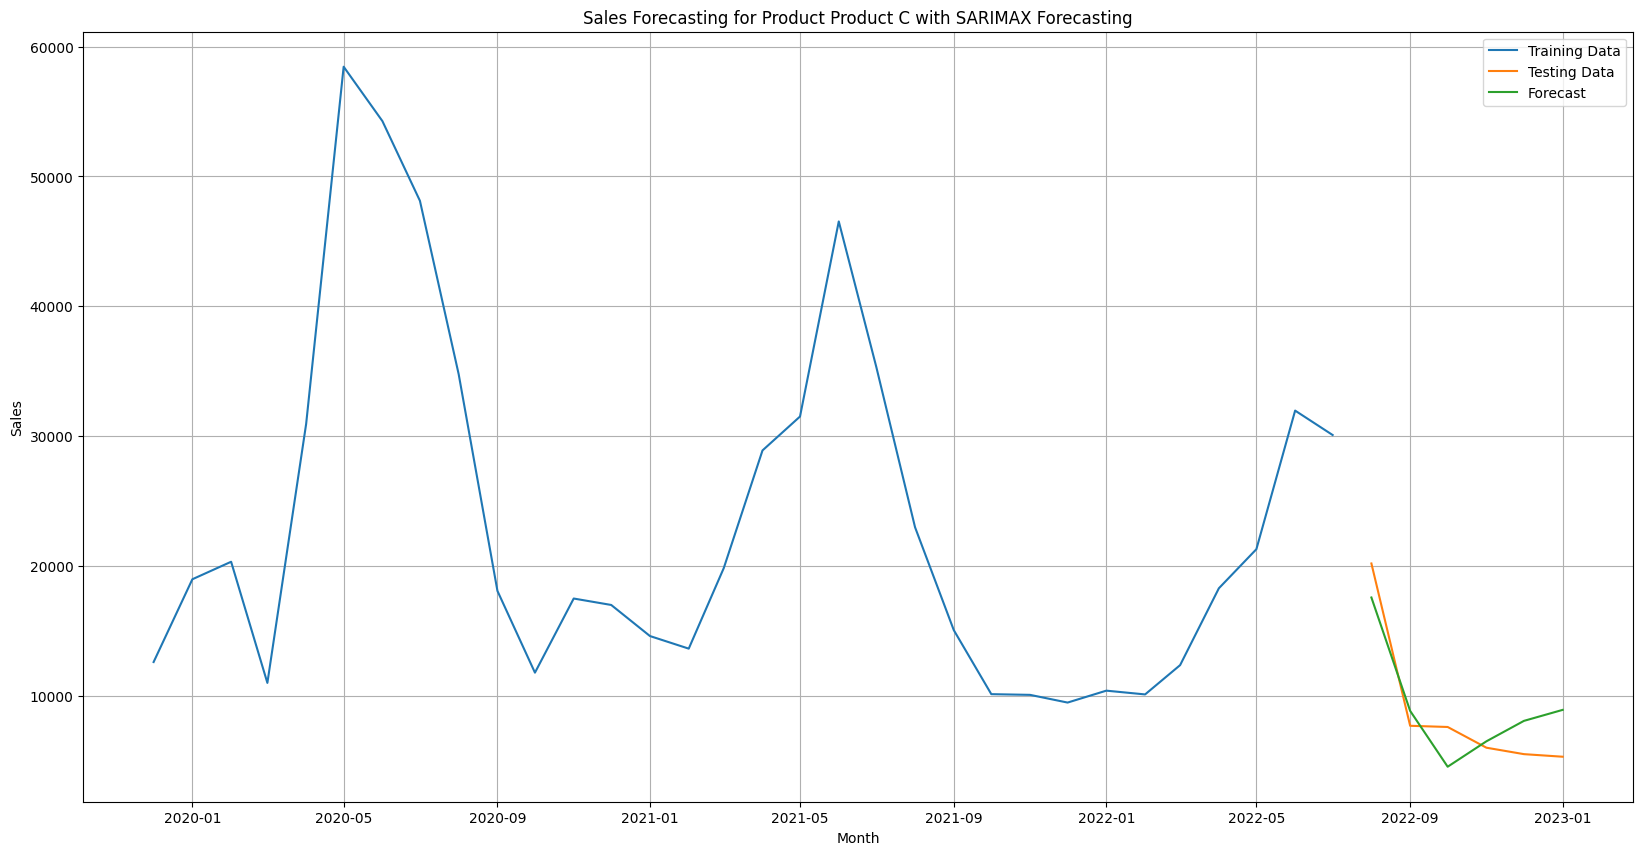

In [103]:
#Calculating all the forecasts using the SARIMAX model
sarimax_A, rmseA_sarimax_nogrid = SARIMAX_model(trainA, testA, name = "SARIMAX Forecasting", product= "Product A")
sarimax_B, rmseB_sarimax_nogrid = SARIMAX_model(trainB, testB, name = "SARIMAX Forecasting", product= "Product B")
sarimax_C, rmseC_sarimax_nogrid = SARIMAX_model(trainC, testC, name = "SARIMAX Forecasting", product= "Product C")

# Implementing Grid Search

I then rewrote the functions so that we could make use of grid search to hypertune the models. This takes around a minute for each product. To make the output easier to read since it runs through many iterations, it only outputs the graph and details of the best performing model. Originally I encountered an error for products B and C. The error was "LinAlgError: LU decomposition error." This was fixed by changing the initialization to 'approximate_diffuse'. 

In [104]:
def SARIMAX_grid(train, test, name, product):
    """
    Perform grid search to find the best parameters for a SARIMAX model.

    Parameters:
    train (pd.DataFrame): The training data containing historical sales.
    test (pd.DataFrame): The test data containing actual sales for evaluation.
    name (str): The name of the forecasting method for plotting.
    product (str): The name or identifier of the product being forecasted.

    Returns:
    forecast (pd.Series): A series containing the forecasted sales for the next 6 months.
    rmse (float): The root mean squared error (RMSE) of the forecast.
    """
    # Define SARIMAX model
    def sarimax_model(endog, order, seasonal_order):
        return SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order, initialization='approximate_diffuse')
    
    # Define parameter grid
    param_grid = {
        'order': [(p, d, q) for p in range(3) for d in range(2) for q in range(3)],
        'seasonal_order': [(P, D, Q, s) for P in range(3) for D in range(2) for Q in range(3) for s in [12]]
    }
    
    best_rmse = np.inf
    best_params = None
    best_model = None
    
    # Loop through parameter grid
    for order in param_grid['order']:
        for seasonal_order in param_grid['seasonal_order']:
            # Create and fit SARIMAX model
            model = sarimax_model(train['Sales'], order=order, seasonal_order=seasonal_order)
            result = model.fit()
            
            # Forecast sales for next 6 months
            forecast = result.forecast(steps=6)
            forecast = np.ceil(forecast)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(test, forecast))
            
            # Update best parameters if RMSE improves
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {'order': order, 'seasonal_order': seasonal_order}
                best_forecast = forecast
    
    print("Best parameters:", best_params)
    
    # Plot training and testing data along with forecast
    plt.figure(figsize=(20,10))
    plt.plot(train, label='Training Data')
    plt.plot(test, label='Testing Data')
    plt.plot(best_forecast, label='Forecast')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecasting for Product {product} with {name}')
    plt.legend()
    plt.grid(True)

    # Calculate RMSE (Root Mean Squared Error)
    print(f'Root Mean Squared Error: {best_rmse}')

    # Show plot
    plt.show()

    return best_forecast, best_rmse


/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf

Best parameters: {'order': (2, 1, 2), 'seasonal_order': (0, 0, 1, 12)}
Root Mean Squared Error: 2898.6640313542143


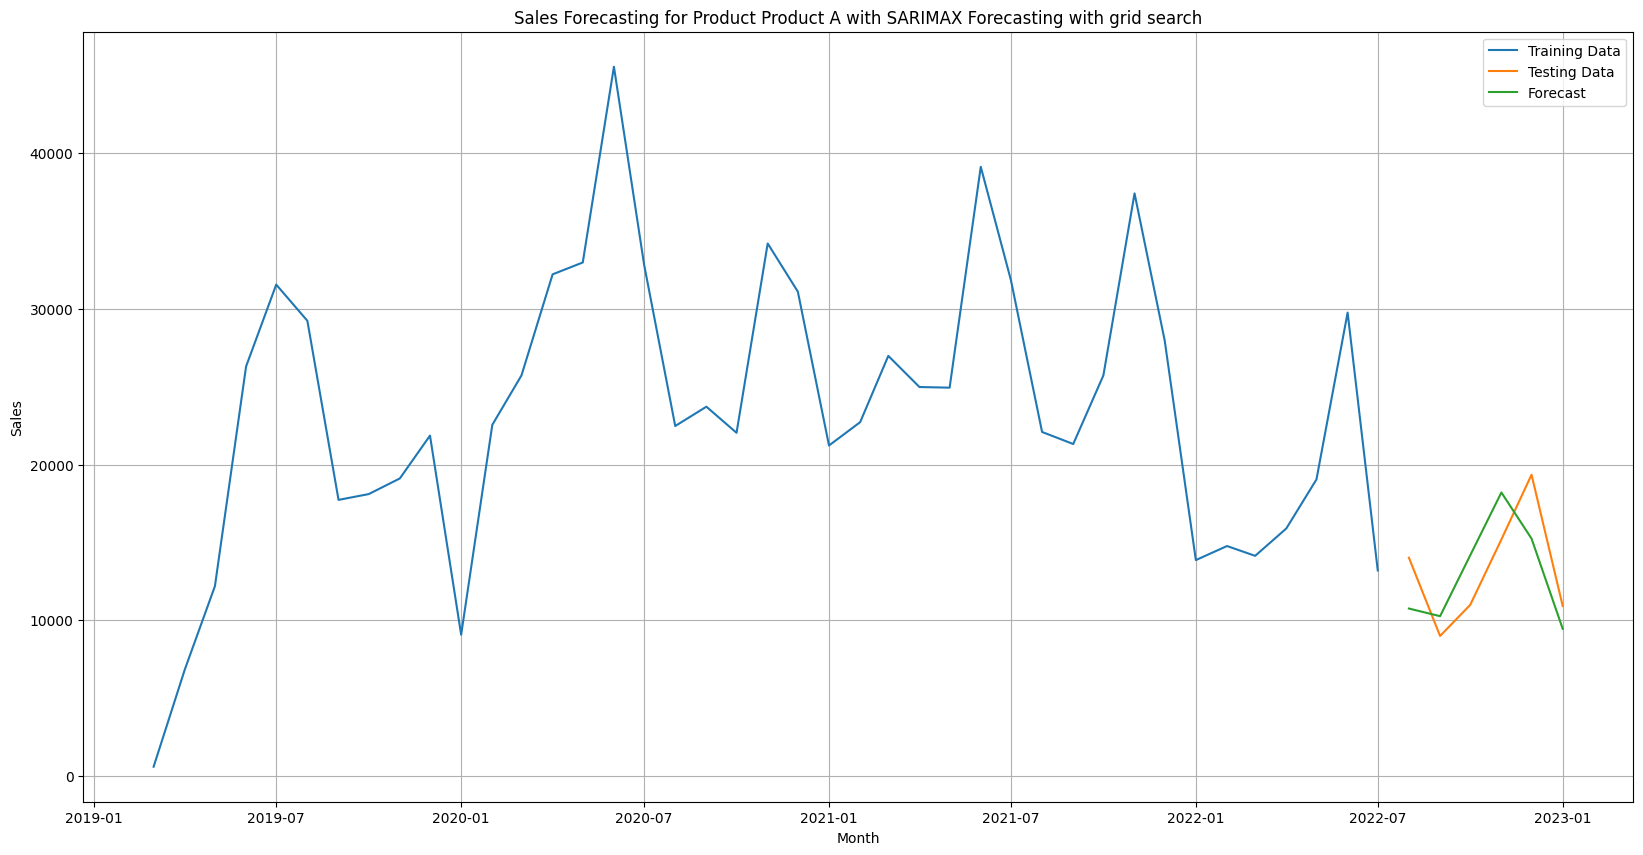

In [105]:
#Calculating the forecasts using SARIMAX and Grid search for product A
sarimax_A, rmseA_sarimax = SARIMAX_grid(trainA, testA, name = "SARIMAX Forecasting with grid search", product= "Product A")

/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf

Best parameters: {'order': (0, 0, 1), 'seasonal_order': (2, 1, 1, 12)}
Root Mean Squared Error: 893.1039506500163


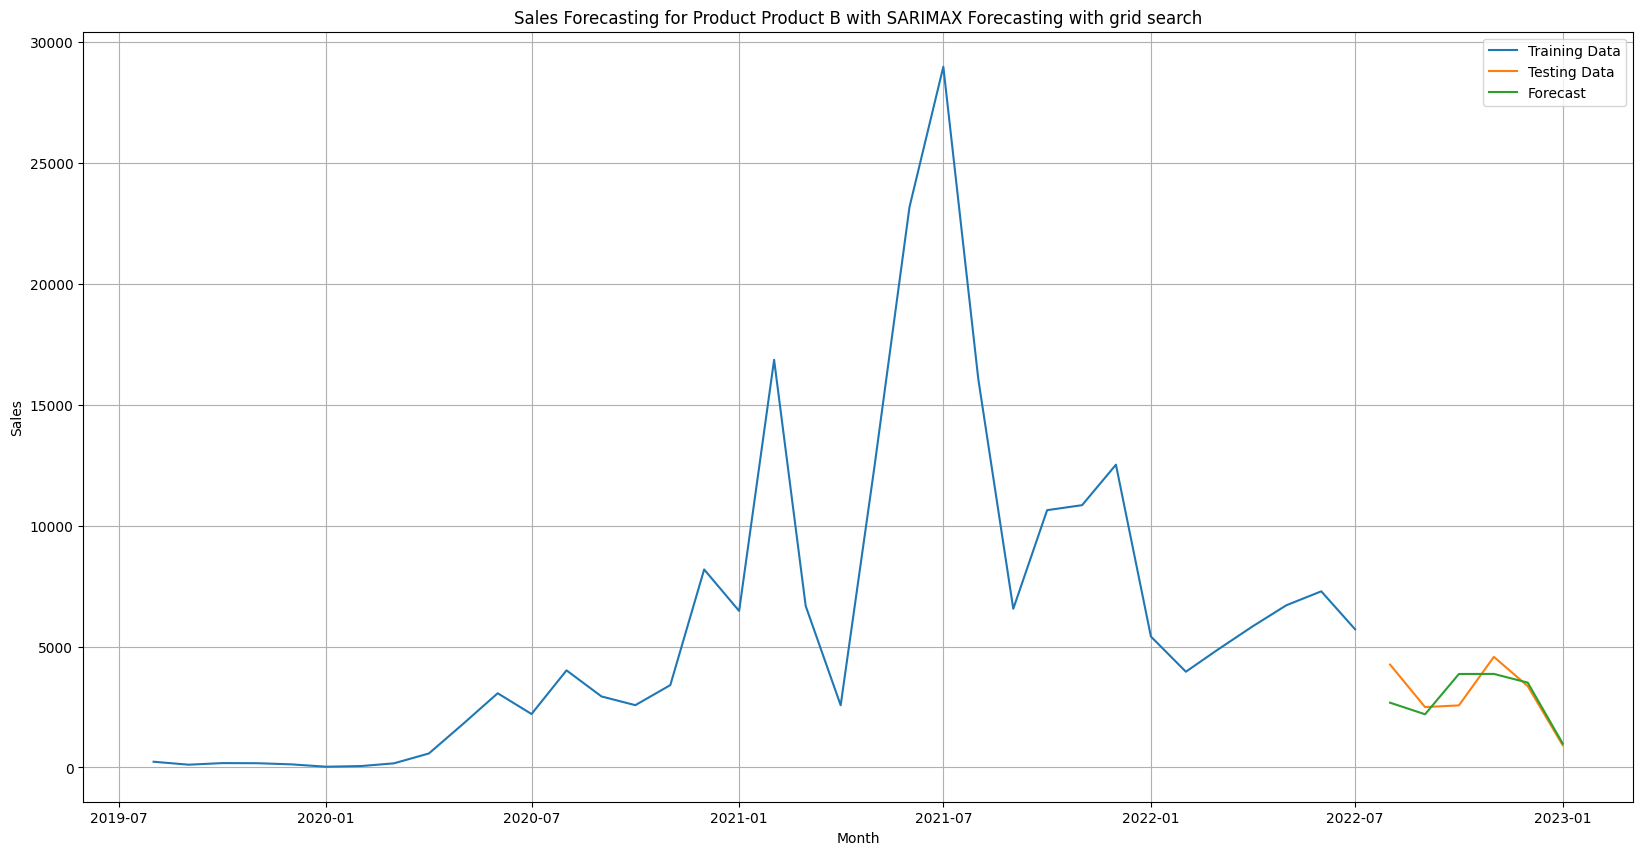

In [106]:
#Calculating the forecasts using SARIMAX and Grid search for product B
sarimax_B, rmseB_sarimax = SARIMAX_grid(trainB, testB, name = "SARIMAX Forecasting with grid search", product= "Product B")

/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/zeidsmac/miniforge3/envs/beerwulf

Best parameters: {'order': (0, 0, 1), 'seasonal_order': (1, 0, 0, 12)}
Root Mean Squared Error: 1111.3711501264252


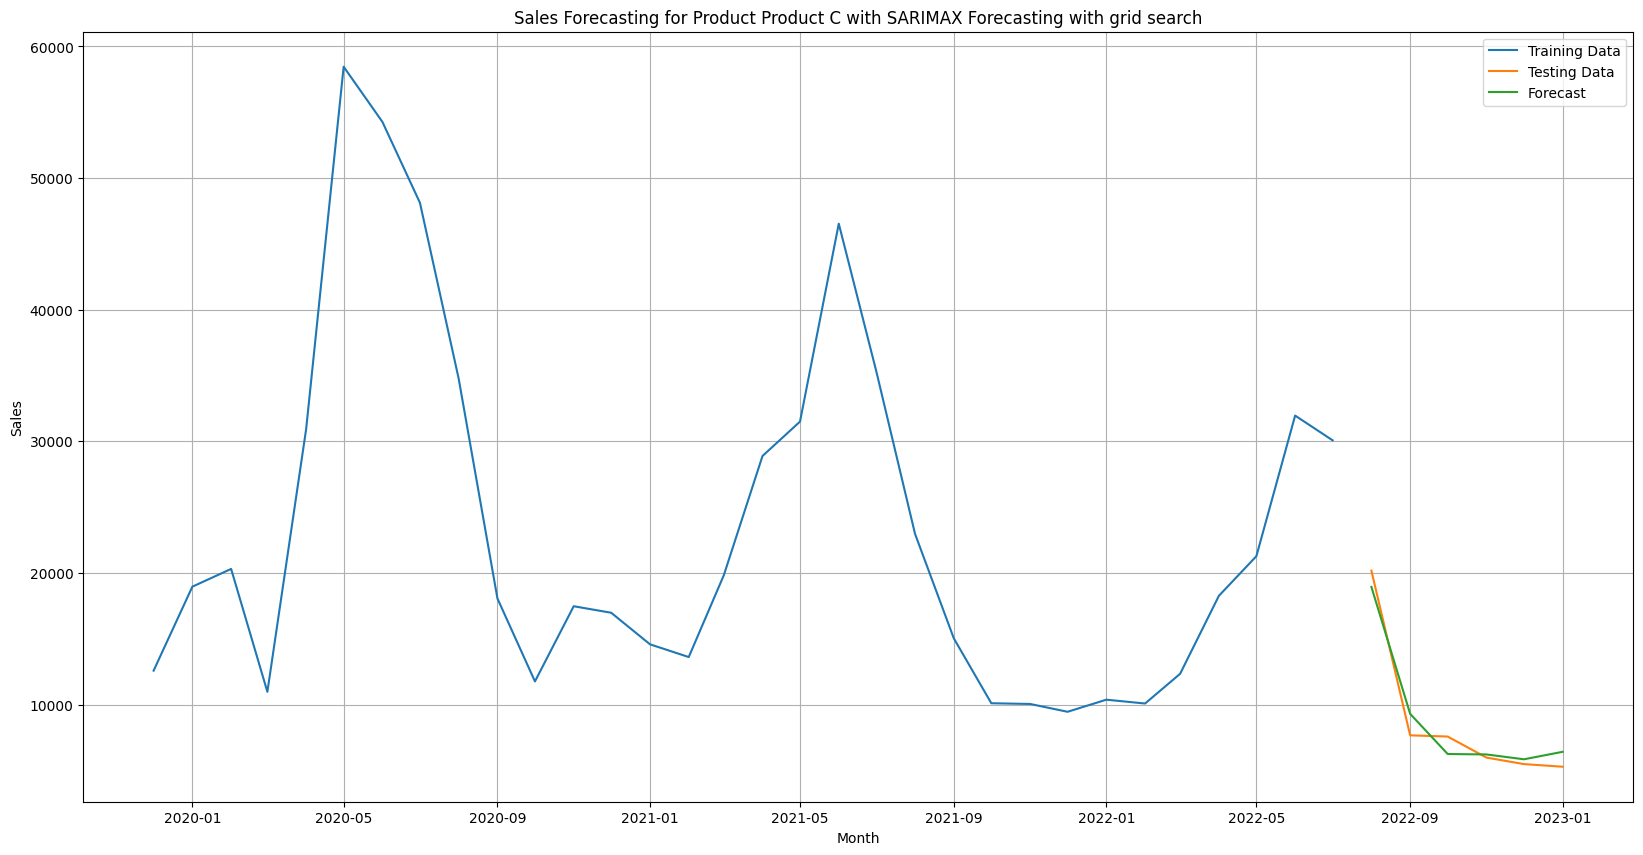

In [107]:
#Calculating the forecasts using SARIMAX and Grid search for product C
sarimax_C, rmseC_sarimax = SARIMAX_grid(trainC, testC, name = "SARIMAX Forecasting with grid search", product= "Product C")

In [108]:
#Printing the results in a table so all the comparisons can be done in a more quantified manner than the graphs
models = ["Total Units sold","Naive", "SARIMAX", "SARIMAX Grid"]
products = ["Product A", "Product B", "Product C", "Total Error"]

naive_total = rmseA_naive + rmseB_naive + rmseC_naive
SARIMAX_total = rmseA_sarimax_nogrid + rmseB_sarimax_nogrid + rmseC_sarimax_nogrid
SARIMAX_grid_total = rmseA_sarimax + rmseB_sarimax + rmseC_sarimax

rmse_values = [
    [rmseA_naive, rmseA_sarimax_nogrid, rmseA_sarimax],
    [rmseB_naive, rmseB_sarimax_nogrid, rmseB_sarimax],
    [rmseC_naive, rmseC_sarimax_nogrid, rmseC_sarimax],
    [naive_total, SARIMAX_total, SARIMAX_grid_total]
]

table_data = []
for i, product in enumerate(products):
    table_data.append([product] + rmse_values[i])
    
print("Sales Forecasting RMSE Results")
print(tabulate(table_data, headers=['Product'] + models, tablefmt='grid'))

Sales Forecasting RMSE Results
+-------------+--------------------+----------+-----------+
| Product     |   Total Units sold |    Naive |   SARIMAX |
+=============+====================+==========+===========+
| Product A   |            3418.13 |  8104.95 |  2898.66  |
+-------------+--------------------+----------+-----------+
| Product B   |            2948.91 |  9061.35 |   893.104 |
+-------------+--------------------+----------+-----------+
| Product C   |           22006.6  |  2497.28 |  1111.37  |
+-------------+--------------------+----------+-----------+
| Total Error |           28373.7  | 19663.6  |  4903.14  |
+-------------+--------------------+----------+-----------+
